In [1]:
import numpy as np
import torch
import pickle
import sys
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff
from torch.nn.functional import normalize

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
prior_min = [.5,1e-4,1e-4,1e-4,50,40,1e-4,35]
prior_max = [80.,15.,0.6,0.6,3000,90,0.15,100]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Simulator

In [4]:
from HH_Helpers import syn_current, calculate_summary_statistics

I, t_on, t_off, dt, t, A_soma = syn_current()

In [5]:
from HH_Helpers import HHsimulator

In [6]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [7]:
def run_HH_model_2(params, duration, dt, t_on, curr_level):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current(duration, dt, t_on, curr_level)

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [8]:
params_base = [[50., 1.],[4., 1.5],[20., 15.]]
params_additional = [0.1,0.07,6e2,60.,.1,70.0]
params = np.array([params_var + params_additional for params_var in params_base])

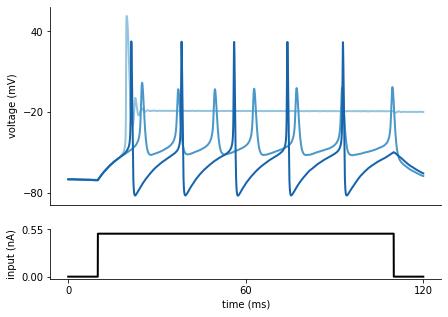

In [9]:
# three sets of (g_Na, g_K)
num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model(params=params[i,:])['data']

# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

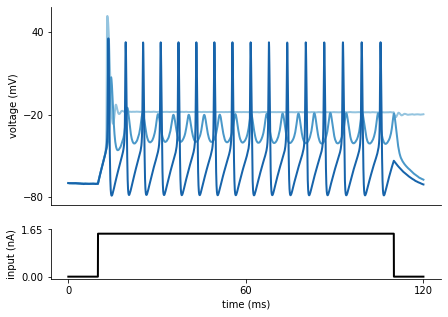

In [10]:
# three sets of (g_Na, g_K)
I, t_on, t_off, dt, t, A_soma = syn_current(120, 0.01,10,1.5e-3)

num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model_2(params=params[i,:], duration=120, dt=0.01,t_on=10,curr_level=1.5e-3)['data']

# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

In [11]:
def summ_simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [12]:
def full_simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = torch.tensor(run_HH_model(params)['data'])
    return obs

## Distances

In [13]:
def hausdorff_dist(x,y, reverse = False):
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    if reverse:
        return directed_hausdorff(y_pairs,x_pairs)
    return directed_hausdorff(x_pairs,y_pairs)
    # x_pairs = torch.vstack([x['time'],x['data']])


## Simulator

In [14]:
true_params = prior.sample()
observation_trace = run_HH_model(true_params)

full_simulator, prior = prepare_for_sbi(full_simulation_wrapper,prior)
theta, data = simulate_for_sbi(full_simulator, prior, num_simulations=100, num_workers=7)

data_np = data.detach().numpy()

time = observation_trace['time']

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
def get_hausdorff_simulator(data):

    def hausdorff_simulator(params, input = None):
        if input is None:
            input = run_HH_model(params)
        distances = []
        for array in data:
            aug_data = {'time':time, 'data':array}
            distances.append(torch.tensor(hausdorff_dist(input,aug_data)[0]))
        return torch.tensor(distances)
    
    return hausdorff_simulator


In [16]:
hausdorff_simulator = get_hausdorff_simulator(data_np)

In [18]:
points_ref = hausdorff_simulator(true_params, observation_trace)
summs_ref = calculate_summary_statistics(observation_trace)

In [19]:
posterior=infer(hausdorff_simulator, prior, method='SNPE', 
                  num_simulations=2000, num_workers=7)

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 206 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

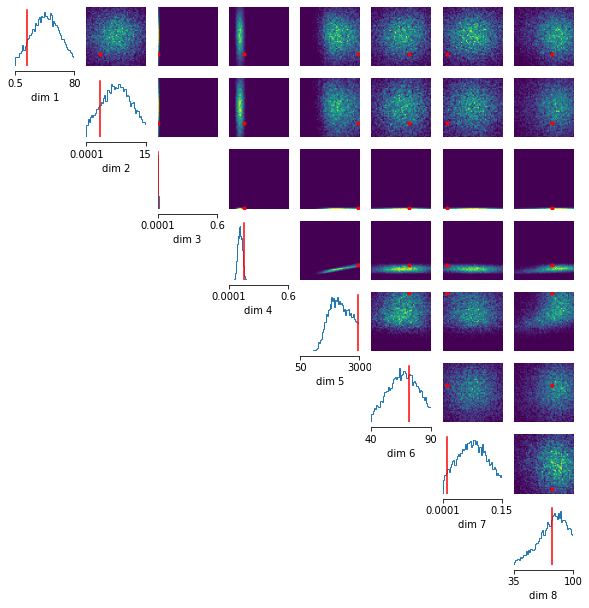

In [28]:
samples = posterior.sample((10000,),x=points_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [21]:
posterior_summ=infer(summ_simulation_wrapper, prior, method='SNPE', 
                  num_simulations=2000, num_workers=7)

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 298 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

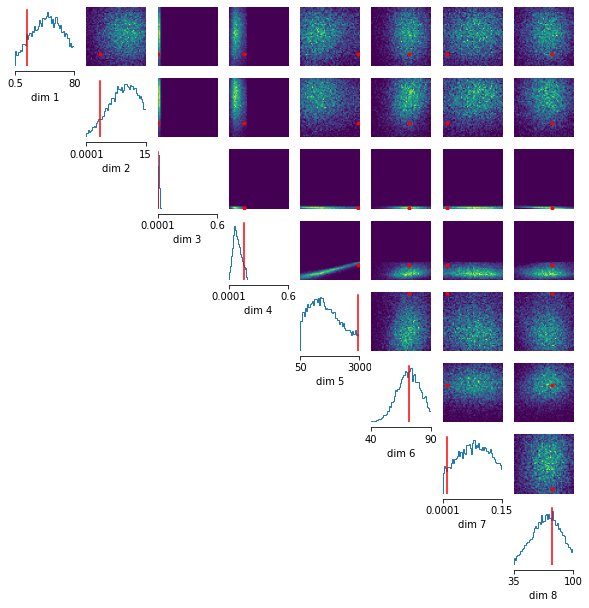

In [29]:
samples = posterior_summ.sample((10000,),x=summs_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [25]:
true_params_2 = prior.sample()
observation_trace_2 = run_HH_model(true_params_2)
points_ref_2 = hausdorff_simulator(true_params_2, observation_trace_2)
summs_ref_2 = calculate_summary_statistics(observation_trace_2)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

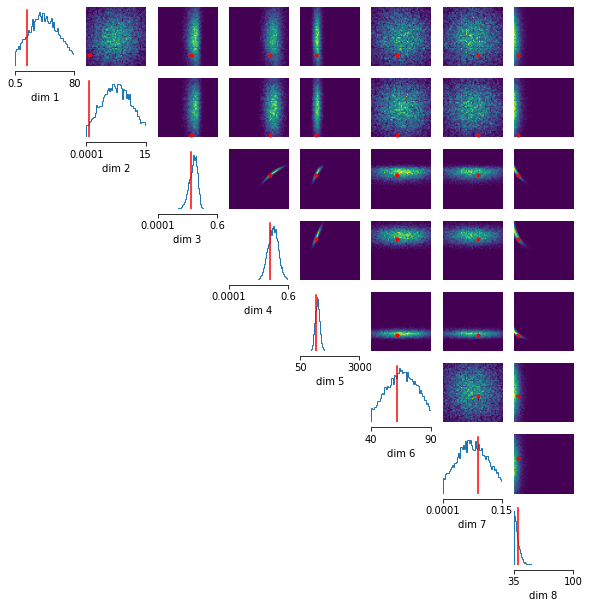

In [31]:
samples = posterior.sample((10000,),x=points_ref_2)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params_2,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

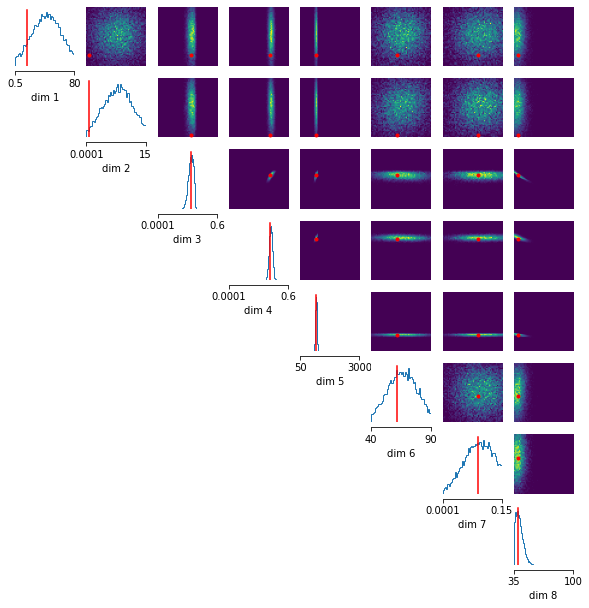

In [30]:
samples = posterior_summ.sample((10000,),x=summs_ref_2)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params_2,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [106]:
with open('test_posterior','wb') as f:
    pickle.dump(posterior,f)

## Multi-round

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 207 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

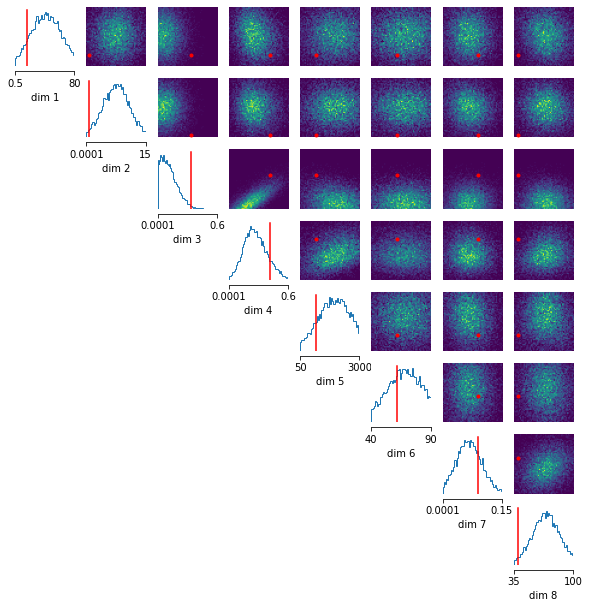

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 104 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 10000 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


KeyboardInterrupt: 

In [36]:
num_rounds = 20
posteriors = []
simulator,prior = prepare_for_sbi(hausdorff_simulator, prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o = points_ref
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=list(zip(prior_min, prior_max)),
                            ticks=list(zip(prior_min, prior_max)),
                            figsize=(10,10),
                            points=true_params_2,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [34]:
x.shape

torch.Size([10000])

## Real data

In [4]:
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from allensdk.core.cell_types_cache import CellTypesCache

ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

cell_specimen_id = 518290966
data_set = ctc.get_ephys_data(cell_specimen_id)

2022-08-11 10:32:08,366 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/566093987


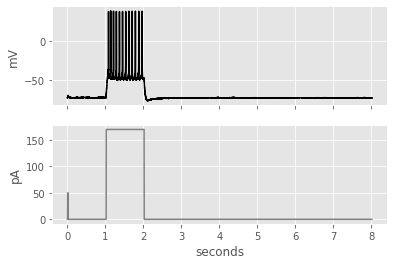

In [7]:
sweep_number = 57
sweep_data = data_set.get_sweep(sweep_number)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t, v, color='black')
axes[1].plot(t, i, color='gray')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
plt.show()

In [13]:
np.ma.masked_array(t,mask=i)

masked_array(data=[0.0, 2e-05, 4e-05, ..., 8.01994, 8.019960000000001,
                   8.01998],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [34]:
t[i>max(i)/2]

array([1.02   , 1.02002, 1.02004, ..., 2.01994, 2.01996, 2.01998])

In [35]:
def plot_response_impulse(cell_specimen_id, sweep_number):
    data_set = ctc.get_ephys_data(cell_specimen_id)
    sweep_data = data_set.get_sweep(sweep_number)

    index_range = sweep_data["index_range"]
    i = sweep_data["stimulus"][0:index_range[1]+1] # in A
    v = sweep_data["response"][0:index_range[1]+1] # in V
    i *= 1e12 # to pA
    v *= 1e3 # to mV

    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)

    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(t, v, color='black')
    axes[1].plot(t, i, color='gray')
    axes[0].set_ylabel("mV")
    axes[1].set_ylabel("pA")
    axes[1].set_xlabel("seconds")
    plt.show()

2022-08-11 11:01:04,830 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/529829375


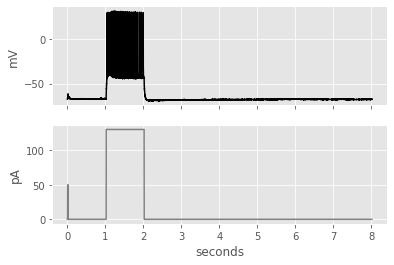

In [36]:
cell_specimen_id, sweep_number = 509881736,39
plot_response_impulse(cell_specimen_id,sweep_number)

2022-08-11 11:01:28,097 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/592968055


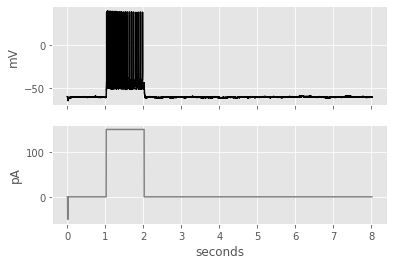

In [37]:
cell_specimen_id, sweep_number = (566517779,46)
plot_response_impulse(cell_specimen_id,sweep_number)

2022-08-11 11:02:09,530 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/592969296


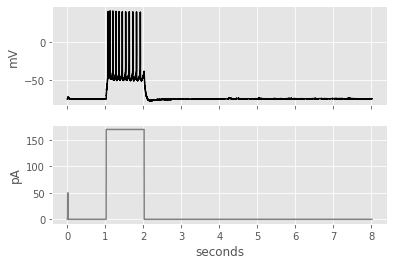

In [38]:
cell_specimen_id, sweep_number = (567399060,38)
plot_response_impulse(cell_specimen_id,sweep_number)

2022-08-11 11:07:08,076 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/592968943


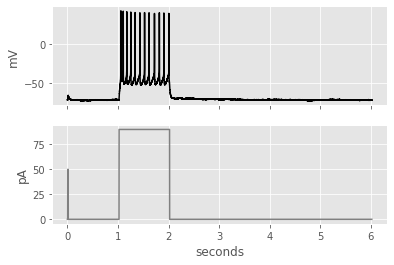

In [39]:
cell_specimen_id, sweep_number = (569469018,44)
plot_response_impulse(cell_specimen_id,sweep_number)

2022-08-11 11:07:12,383 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/567444866


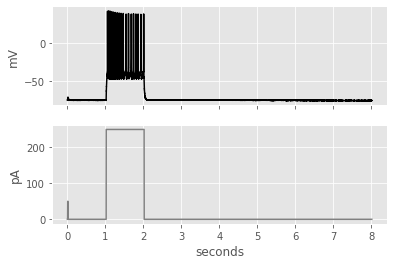

In [40]:
cell_specimen_id, sweep_number = (532571720,42)
plot_response_impulse(cell_specimen_id,sweep_number)

2022-08-11 11:07:19,702 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/592967835


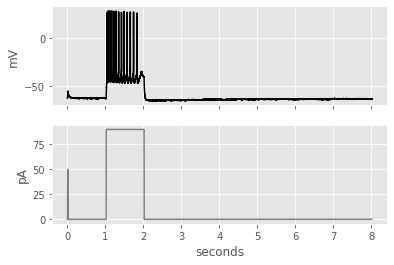

In [41]:
cell_specimen_id, sweep_number = (555060623,34)
plot_response_impulse(cell_specimen_id,sweep_number)

2022-08-11 11:07:24,196 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/567444658


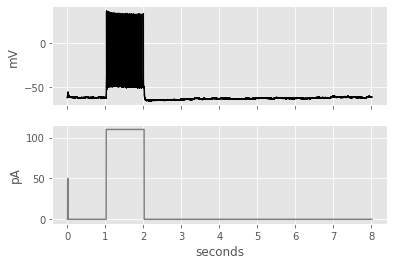

In [42]:
cell_specimen_id, sweep_number = (534524026,29)
plot_response_impulse(cell_specimen_id,sweep_number)

In [44]:
def print_impulse_peak(cell_specimen_id,sweep_number):
    data_set = ctc.get_ephys_data(cell_specimen_id)
    sweep_data = data_set.get_sweep(sweep_number)

    index_range = sweep_data["index_range"]
    i = sweep_data["stimulus"][0:index_range[1]+1] # in A
    v = sweep_data["response"][0:index_range[1]+1] # in V
    i *= 1e12 # to pA
    v *= 1e3 # to mV

    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)

    print(t[i>0.75*max(i)])

id_sweep = [(518290966,57), (509881736,39), (566517779,46),(567399060,38), (569469018,44), (532571720,42), (555060623,34), (534524026,29)]

for id, sweep in id_sweep:
    print_impulse_peak(id,sweep)


[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]
[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]
[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]
[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]
[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]
[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]
[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]
[1.02    1.02002 1.02004 ... 2.01994 2.01996 2.01998]


In [56]:
params_test = prior.sample((5,))
observations = [run_HH_model(param) for param in params_test]


In [59]:
with open('test_obs_dump','wb') as f:
    pickle.dump(observations,f)


## Sequential Simulator

In [20]:
params = torch.tensor([50.,5.,0.1,0.07,6e2,60.,.1,70.0])
obs_trace = run_HH_model(params)

In [21]:
def get_hausdorff_simulator(data):

    def hausdorff_simulator(params, input = None):
        if input is None:
            input = run_HH_model(params)
        distances = []
        for array in data:
            aug_data = {'time':time, 'data':array}
            distances.append(torch.tensor(hausdorff_dist(input,aug_data)[0]))
        return torch.tensor(distances)
    
    return hausdorff_simulator

hausdorff_simulator = get_hausdorff_simulator(data_np)

points_ref = hausdorff_simulator(params, obs_trace)
summs_ref = calculate_summary_statistics(obs_trace)

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 138 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

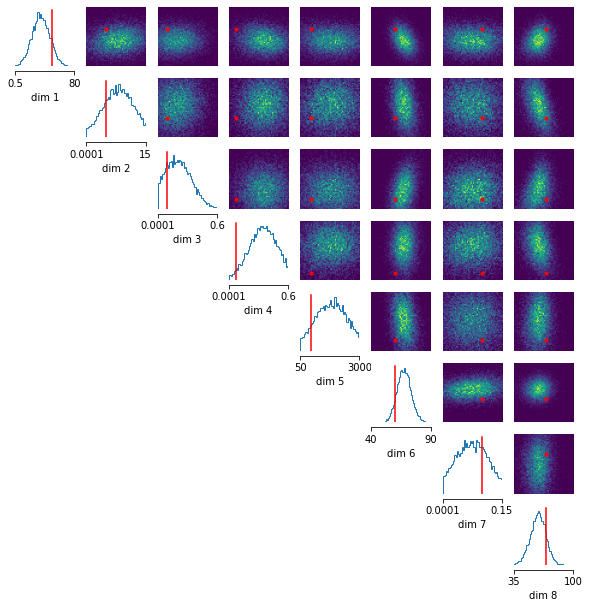

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

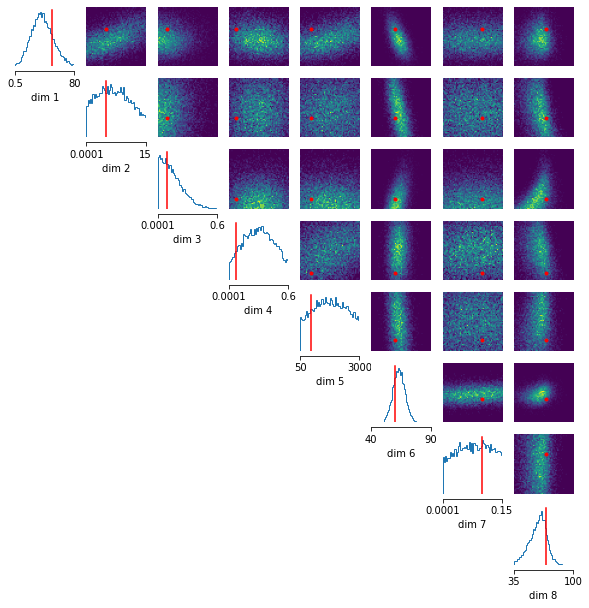

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

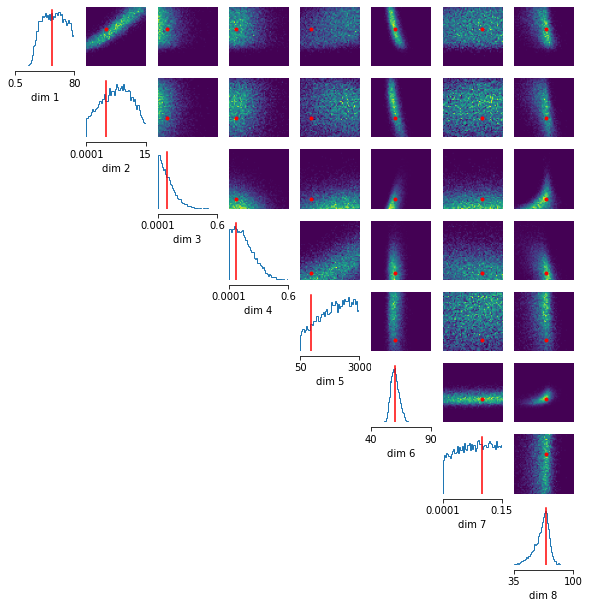

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 75 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9978 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


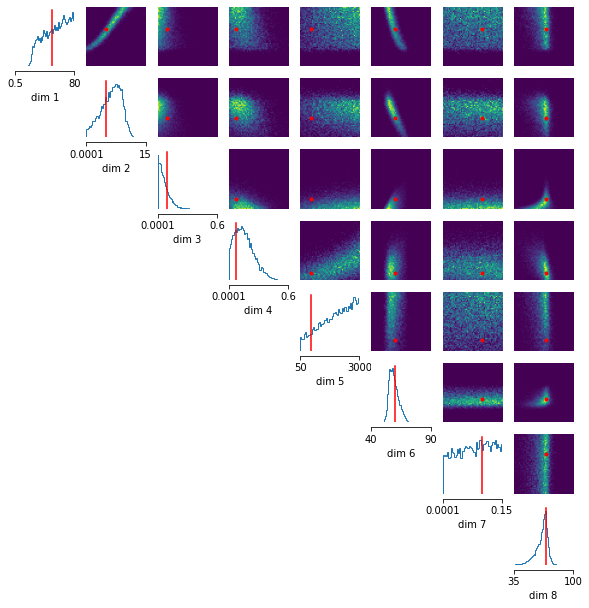

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 163 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 81 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9995 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


KeyboardInterrupt: 

In [22]:
# Try the full simulator sans grid.

num_rounds = 10
posteriors_full = []
simulator, prior = prepare_for_sbi(summ_simulation_wrapper, prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors_full.append(posterior)
    proposal = posterior.set_default_x(summs_ref)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
    plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

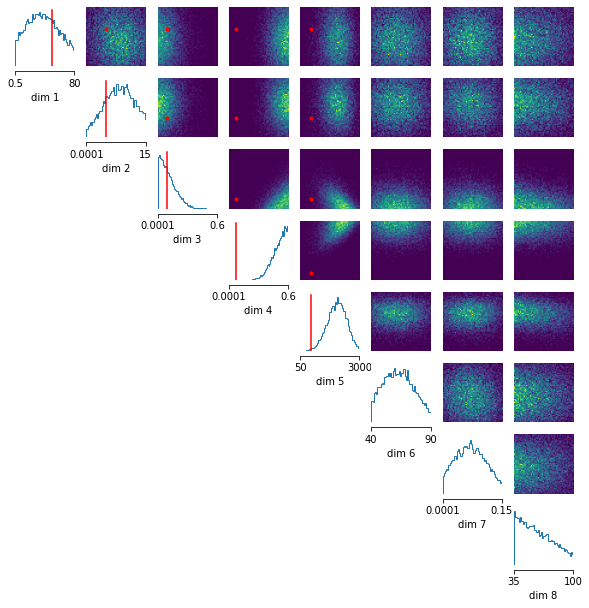

In [36]:
samples = posterior.sample((10000,))
fig, axes = analysis.pairplot(samples,
                    limits=list(zip(prior_min, prior_max)),
                    ticks=list(zip(prior_min, prior_max)),
                    figsize=(10,10),
                    points=torch.tensor(params),
                    points_offdiag={'markersize': 6},
                    points_colors='r');
plt.show()

In [37]:
params

[50.0, 5.0, 0.1, 0.07, 600.0, -60.0, -0.1, -70.0]

## Ideas

Three methods to iteratively update distance summaries.

1. Take a point between new point and closest old point.
2. Same as above, but including the restriction that we can't use the same closest old point. This prevents the risk of bunching where points conglomerate and never detach becoming uninformative. What would the mechanism be? e.g. Associate each point with another such that the sum of distance is minimised.
3. A method which somehow includes the weightings of the various points according to the estimated posteriors. 

How might we implement 3? One example would be to take a weighting of a point with ALL other points; this would be like moving towards the  mean of the posterior. This could be tricky with multimodal distribution and such.